In [1]:
import os

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

sns.set_style("whitegrid")

In [2]:
baxter_path = '../benchmarking/Baxter/benchmarks.csv'
embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
deepcell_path = '../benchmarking/DeepCell/benchmarks.csv'
tracx_path = '../benchmarking/TracX/benchmarks.csv'

sum_columns = [
    'correct_division', 'mismatch_division',
    'false_positive_division', 'false_negative_division', 'total_divisions',
    'aa_tp', 'aa_total', 'te_tp', 'te_total']
mean_columns = ['DET', 'SEG', 'TRA']

In [18]:
paths = [deepcell_path, baxter_path, embedtrack_path, tracx_path]
dfs = []
for path in paths:
    sdf = pd.read_csv(path, index_col=0)
    
    # Rollup data for each model version
    sdf_a = sdf[['model'] + sum_columns].groupby('model').sum().reset_index()
    sdf_b = sdf[['model'] + mean_columns].groupby('model').mean().reset_index()
    sdf = sdf_a.merge(sdf_b, on='model')
    dfs.append(sdf)
    
df = pd.concat(dfs).set_index('model')

In [19]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

df = df.join(df.apply(calculate_stats, axis=1))

In [20]:
df

,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,DET,SEG,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Fraction missed divisions,Association Accuracy,Target Effectiveness
model,,,,,,,,,,,,,,,,,,,
Deepcell - Deepcell,151.0,11.0,10.0,16.0,178.0,47007.0,48390.0,48364.0,49775.0,0.990764,0.923929,0.989835,0.90,0.94,0.92,0.85,0.09,0.97,0.97
Deepcell - GT,169.0,1.0,3.0,8.0,178.0,47908.0,48390.0,49293.0,49775.0,1.000000,1.000000,0.999636,0.95,0.98,0.97,0.94,0.04,0.99,0.99
Baxter - Deepcell,86.0,7.0,30.0,85.0,178.0,47610.0,48390.0,48911.0,49775.0,0.988279,0.919609,0.987211,0.50,0.74,0.60,0.43,0.48,0.98,0.98
Baxter - GT,104.0,6.0,13.0,68.0,178.0,48171.0,48390.0,49493.0,49775.0,0.997080,0.996160,0.996567,0.60,0.89,0.72,0.56,0.38,1.00,0.99
EmbedTrack - Fluo-N2DH-GOWT1,0.0,0.0,15.0,108.0,108.0,4850.0,29504.0,5192.0,30321.0,0.238841,0.179327,0.231180,0.00,0.00,0.00,0.00,1.00,0.16,0.17
EmbedTrack - Fluo-N2DH-SIM+,0.0,7.0,1500.0,171.0,178.0,25167.0,48390.0,26326.0,49775.0,0.826697,0.397969,0.779315,0.00,0.00,0.00,0.00,0.96,0.52,0.53
EmbedTrack - Fluo-N2DL-HeLa,108.0,10.0,533.0,60.0,178.0,39605.0,48390.0,40739.0,49775.0,0.816220,0.641730,0.815163,0.64,0.17,0.27,0.15,0.34,0.82,0.82
TracX - Deepcell,42.0,45.0,121.0,91.0,178.0,45986.0,48390.0,47343.0,49775.0,0.990764,0.923929,0.989102,0.32,0.26,0.28,0.17,0.51,0.95,0.95
TracX - GT,42.0,56.0,36.0,80.0,178.0,47293.0,48390.0,48678.0,49775.0,1.000000,1.000000,0.998686,0.34,0.54,0.42,0.27,0.45,0.98,0.98


# Plotting

In [ ]:
# Color brewer paired colors
paired_cb = sns.color_palette("Paired").as_hex()

colors_colorbrewer = {
    'Deepcell - Deepcell': paired_cb[0], #light blue
    'Deepcell - GT': paired_cb[1], #dark blue
    
    'Baxter - Deepcell': paired_cb[2], #light green
    'Baxter - GT': paired_cb[3], #dark green
    
    # Only show the best embedtrack result
    # 'EmbedTrack - Fluo-N2DH-GOWT1': cm.tab20(norm(5)),
    # 'EmbedTrack - Fluo-N2DH-SIM+': cm.tab20(norm(7)),
    'EmbedTrack - Fluo-N2DL-HeLa': paired_cb[8], 
    
    'TracX - Deepcell': paired_cb[4],
    'TracX - GT': paired_cb[5],
}

In [9]:
# Norm for tab20 colormap
norm = Normalize(vmin=0, vmax=19)

# GT segs are even numbers
colors = {
    'Baxter - GT': cm.tab20(norm(0)),
    'Baxter - Deepcell': cm.tab20(norm(1)),
    'Deepcell - GT': cm.tab20(norm(2)),
    'Deepcell - Deepcell': cm.tab20(norm(3)),
    # 'EmbedTrack - Fluo-N2DH-GOWT1': cm.tab20(norm(5)),
    # 'EmbedTrack - Fluo-N2DH-SIM+': cm.tab20(norm(7)),
    'EmbedTrack - Fluo-N2DL-HeLa': cm.tab20(norm(9)), # Only show the best embedtrack result
    'TracX - GT': cm.tab20(norm(10)),
    'TracX - Deepcell': cm.tab20(norm(11))
}

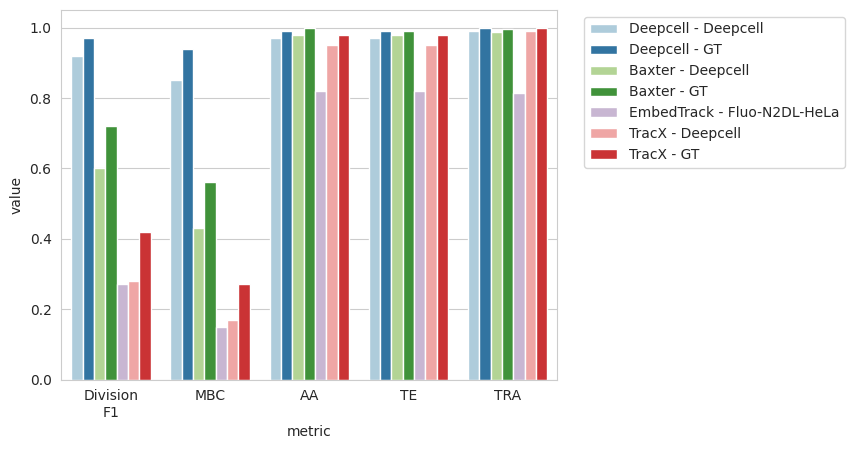

In [44]:
labels = {
    # 'Division Precision': 'Division\nPrecision',
    # 'Division Recall': 'Division\nRecall',
    'Division F1': 'Division\nF1',
    'Mitotic branching correctness': 'MBC',
    'Association Accuracy': 'AA',
    'Target Effectiveness': 'TE'
}

stats_columns = ['Division F1', 'Mitotic branching correctness', 'Association Accuracy', 'Target Effectiveness', 'TRA']

sdf = df.loc[list(colors_colorbrewer.keys())] # Limit models to those under consideration
sdf = sdf[stats_columns] # Limit columns
sdf = sdf.reset_index() # Reset index to expose model as column

stats = sdf.melt(
    id_vars='model',
    value_vars=stats_columns,
    var_name='metric'
    )
stats = stats.replace(labels) # Rename metrics for better plotting

sns.barplot(
    data=stats,
    x='metric',
    y='value',
    hue='model',
    palette=colors_colorbrewer
) 
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")